In [1]:
from pathlib import Path
import os
from dotenv import load_dotenv
import json

import pandas as pd
import geopandas as gpd

from dataclasses import dataclass, fields

from streettransformer.alignment.validate import set_up_validation_dataframe
from streettransformer.llms.queries import QueryOutput, ChangeIdentifierOutput

load_dotenv()
OUTPUT_PATH = Path('../data_oai_files/results')
DB_PATH = Path(str(os.getenv('DB_PATH')))


# Load in 'database'

In [2]:
document_files = pd.read_parquet(DB_PATH / "document_files.parquet")
locations = gpd.read_parquet(DB_PATH / "locations.parquet")
project_total_scopes = pd.read_parquet(DB_PATH / "project_total_scopes.parquet")
project_safety_scopes = pd.read_parquet(DB_PATH / "project_safety_scopes.parquet")
project_geos = gpd.read_parquet(DB_PATH / "project_geos.parquet")
projects = pd.read_parquet(DB_PATH / "projects.parquet")
location_year_files = pd.read_parquet(DB_PATH / "location_year_files.parquet")
document_collections = pd.read_parquet(DB_PATH / "document_collections.parquet")
location_to_project = pd.read_parquet(DB_PATH / "_location_to_project.parquet")
location_to_document_collection = pd.read_parquet(DB_PATH / "_location_to_document_collection.parquet")
imgs_to_filesAPI = pd.read_parquet(DB_PATH / '_imgs_to_filesAPI.parquet')
docs_to_filesAPI = pd.read_parquet(DB_PATH / '_docs_to_filesAPI.parquet')
image_pairs = pd.read_parquet(DB_PATH / 'processed' / 'image_pairs.parquet')


# Classifier

In [20]:

output_df = pd.read_json(OUTPUT_PATH / 'image_identifier-4o.csv', lines=True)

ground_truth_df = pd.read_parquet(DB_PATH /'groundtruth/change_identifier_classes.parquet')
ground_truth_df

RESPONSE_COLUMNS = ['change_detected', 'features','confidence']
INDEX_COLUMNS    = ['location_id', 'year_start', 'year_end']
results_df = output_df['output_text'].apply(pd.Series)

validate_df = pd.concat([
    output_df['item_id'].str.split('-', expand=True).set_axis(INDEX_COLUMNS, axis=1),
    output_df[['model']], 
    results_df[RESPONSE_COLUMNS]
], axis=1, join='inner')
validate_df['location_id'] = validate_df['location_id'].astype(int)

validate_df.merge(
    ground_truth_df,
    on = INDEX_COLUMNS
).groupby(['change_identifier_total'])['change_detected'].agg(['count','mean']).rename(columns={'mean':'pos_share'}).style.background_gradient(cmap='Greens', subset='pos_share')#.value_counts(normalize=True).unstack().T#[[True, False]]
##addtnl_results
#classified_df[COLUMNS]
#results_df[results_df['item_id'].str.split('-', expand=True)

,count,pos_share
change_identifier_total,,
Change Between,670,0.883582
Change On Year,9,0.555556
Change Out of Range,134,0.798507
No Change,49,0.653061


# Identifier

In [ ]:
# First need to build ground truth
# locations.merge(
#     location_to_project,
#     on = 'location_id',
#     how='left'
# ).merge(
#     project_total_scopes.groupby('citydata_proj_id')['total_scope'].agg(list),
#     how='left',
#     on = 'citydata_proj_id'  
# ).merge(
#     project_safety_scopes.groupby('citydata_proj_id')['safety_scope'].agg(list),
#     how='left',
#     on = 'citydata_proj_id'  
# ).drop(['index_right','geometry', 'crossstreets'],axis=1).to_parquet(DB_PATH / 'groundtruth' / 'location_to_scopes.parquet')#['citydata_proj_id'].isna().sum() # 297 don't have projects at all

pd.read_parquet(DB_PATH / '')

# # project_total_scopes
# # project_safety_scopes

#project_safety_scopes.rename(columns={'SafetyScope': 'safety_scope'}).to_parquet(DB_PATH / 'project_safety_scopes.parquet')

In [ ]:
id_cols = ['location_id', 'year_start', 'year_end']

gt_class_col = 'total_scope'
rs_class_col = 'features'
response_df = pd.read_json(OUTPUT_PATH / 'image_identifier-4o.csv', lines=True)
ground_truth_df = pd.read_parquet(DB_PATH /'groundtruth/location_to_scopes.parquet')

results_df = response_df['output_text'].apply(pd.Series)
results_cols = [f.name for f in fields(ChangeIdentifierOutput)]

unified_response_df = pd.concat([
        response_df['item_id'].str.split('-', expand=True).set_axis(id_cols, axis=1),
        response_df['model'],
        results_df[results_cols]
    ], axis=1, join='inner')
unified_response_df['location_id'] = unified_response_df['location_id'].astype(int)
unified_response_df

validate_df = unified_response_df[id_cols + [rs_class_col]].merge(
        ground_truth_df[id_cols + [gt_class_col]],
        on=id_cols
    )

,location_id,sample_source,citydata_proj_id,distance,total_scope,safety_scope
0,43609,Safety,2836.0,0.179325,"[Partial Reconstruction, Raised Median, Bus Bu...","[Raised Median, Bus Bulb, Curb Extensions]"
1,41675,Safety,315.0,177.099527,"[Partial Reconstruction, Median Tip Extension,...","[Median Tip Extension, Bus Bulb, Curb Extensions]"
2,41675,Safety,315.0,0.249511,"[Partial Reconstruction, Median Tip Extension,...","[Median Tip Extension, Bus Bulb, Curb Extensions]"
3,37511,Safety,2860.0,0.292503,"[Partial Reconstruction, Median Tip Extension,...","[Median Tip Extension, Curb Extensions]"
4,54810,Safety,1398.0,0.267454,"[Bus Bulb, Curb Extensions]","[Bus Bulb, Curb Extensions]"
...,...,...,...,...,...,...
4312,36332,postIntervention,2005.0,0.280786,"[Curb to Curb Reconstruction, Sidewalks]",None
4313,9061704,postIntervention,2785.0,28.946423,"[Curb to Curb Reconstruction, Sidewalks]",None
4314,9061704,postIntervention,2785.0,256.647483,"[Curb to Curb Reconstruction, Sidewalks]",None
4315,9061704,postIntervention,86.0,28.946423,"[Curb to Curb Reconstruction, Sidewalks]",None


# Look at both classifier and identifier

In [31]:
validate_sidebyside_df = set_up_validation_dataframe(
    'sidebyside_identifier-4o.csv', 
    'location_pair_change_identifier.parquet',
    'change_identifier_total',
    #'change_identifier_safety',
    'change_detected'
)

validate_imagery_df = set_up_validation_dataframe(
    'image_identifier-4o.csv', 
    'location_pair_change_identifier.parquet',
    'change_identifier_total',
    #'change_identifier_safety',
    'change_detected'
)

In [33]:
validate_imagery_df.groupby('true_class')['pred_class'].agg(['count','mean'])
#validate_sidebyside_df.groupby('true_class')['pred_class'].agg(['count','mean'])

#validate_sidebyside_df['true_class']
#validate_imagery_df['true_class'].value_counts()

,count,mean
true_class,,
Change Between,851,0.893067
Change On Year,21,0.761905
Change Out of Range,201,0.825871


# Describers - 

In [8]:
import pandas as pd
from streettransformer.alignment.sentence_compare import compare_sentence_pairs
OAI_RESULTS = Path('../data_oai_files/results')

# results_file1

In [20]:
doc_summary_response_df        = pd.read_json(OAI_RESULTS / 'summarizer-document-4o.csv', lines=True)
image_summary_response_df      = pd.read_json(OAI_RESULTS / 'summarizer-image-4o.csv', lines=True)
sidebyside_summary_response_df = pd.read_json(OAI_RESULTS / 'summarizer-sidebyside-4o.csv', lines=True)

In [35]:
# Docs
doc_results = doc_summary_response_df[['item_id', 'model']].copy()
doc_results['item_id'] = doc_results['item_id'].str.strip("\"")
doc_results['text_output'] = doc_summary_response_df['output_text'].apply(pd.Series)['description']

# Images
image_results = image_summary_response_df[['item_id', 'model']].copy()
image_results['item_id'] = image_results['item_id'].str.strip("\"")
image_results['text_output'] = image_summary_response_df['output_text'].apply(pd.Series)['description']

# SidebySide
sidebyside_results = sidebyside_summary_response_df[['item_id', 'model']].copy()
sidebyside_results['item_id'] = sidebyside_results['item_id'].str.strip("\"")
sidebyside_results['text_output'] = sidebyside_summary_response_df['output_text'].apply(pd.Series)['description']

In [ ]:
# NOw join them togeter
doc_to_image_summaries = doc_results.merge(
    image_results,
    on = 'item_id',
    how='outer', indicator=True,
    suffixes=['_doc', '_image']
)

doc_to_image_summaries['_merge'].value_counts() # Hmm some right only that's weird. Let's just ignore

doc_to_image_summaries[doc_to_image_summaries['_merge'] == 'both']
doc_to_image_summaries_noNA = doc_to_image_summaries.dropna().reset_index()

doc_to_image_summaries_noNA['raw_cosine_similarity'] = compare_sentence_pairs(
    doc_to_image_summaries_noNA['text_output_doc'],
    doc_to_image_summaries_noNA['text_output_image']
)


mean: 0.8472703099250793


<Axes: >

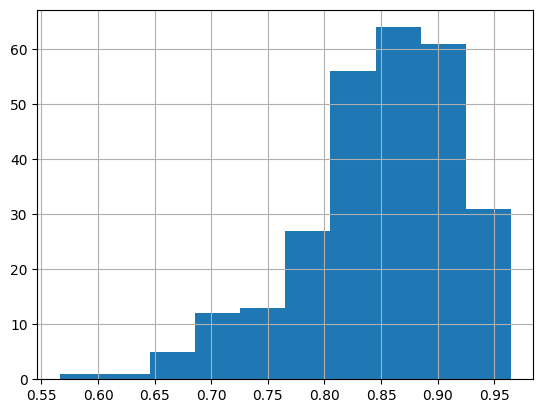

In [ ]:
print(f"mean: {doc_to_image_summaries_noNA['raw_cosine_similarity'].mean()}") #.847
doc_to_image_summaries_noNA['raw_cosine_similarity'].hist()

In [62]:
# Make it a function
def _read_and_clean_summarizer_results(response_path:Path) -> pd.DataFrame:
    response_df = pd.read_json(OAI_RESULTS / response_path, lines=True)
    results = response_df[['item_id', 'model']].copy()
    results['item_id'] = results['item_id'].str.strip("\"")
    results['text_output'] = response_df['output_text'].apply(pd.Series)['description']
    return results

def validate_summarizers(summaries1_path: Path, summaries2_path: Path):
    results1_df = _read_and_clean_summarizer_results(summaries1_path)
    results2_df = _read_and_clean_summarizer_results(summaries2_path)

    joined_summaries = results1_df.merge(
        results2_df,
        on = 'item_id',
        how='outer', indicator=True,
        suffixes=['_1', '_2']
    )

    joined_summaries = joined_summaries.dropna().reset_index()

    joined_summaries['raw_cosine_similarity'] = compare_sentence_pairs(
        joined_summaries['text_output_1'],
        joined_summaries['text_output_2']
    )
    
    print(f"mean: {joined_summaries['raw_cosine_similarity'].mean()}")
    return joined_summaries


In [64]:
'summarizer-document-4o.csv'
'summarizer-image-4o.csv'
'summarizer-sidebyside-4o.csv'

validate_summarizers('summarizer-document-4o.csv', 'summarizer-image-4o.csv')
validate_summarizers('summarizer-document-4o.csv', 'summarizer-sidebyside-4o.csv')
validate_summarizers('summarizer-image-4o.csv', 'summarizer-sidebyside-4o.csv')

mean: 0.8472703099250793
mean: 0.8457691669464111
mean: 0.8999789953231812


,index,item_id,model_1,text_output_1,model_2,text_output_2,_merge,raw_cosine_similarity
0,0,102197-2006-2012-21-25,gpt-4o,The intersection features expanded median pede...,gpt-4o,The intersection underwent a lane removal or r...,both,0.925202
1,1,102198-2006-2012-21-26,gpt-4o,The intersection has added a new median/pedest...,gpt-4o,The changes include the addition of a new bike...,both,0.815215
2,2,102216-2006-2012-21-27,gpt-4o,The median has been extended to create a new p...,gpt-4o,The intersection underwent a redesign with a n...,both,0.921679
3,3,102839-2006-2012-41-57,gpt-4o,The intersection features a significant lane r...,gpt-4o,The intersection underwent a lane removal or r...,both,0.936808
4,4,103248-2006-2012-52-76,gpt-4o,The intersection streetscape shows the additio...,gpt-4o,The intersection has been modified with the ad...,both,0.903969
...,...,...,...,...,...,...,...,...
319,320,92792-2018-2024-561-842,gpt-4o,The intersection has been modified with curb e...,gpt-4o,The intersection has added curb extensions and...,both,0.963358
320,321,92894-2012-2018-271-377,gpt-4o,A new raised median has been added in the cent...,gpt-4o,The intersection shows a new or expanded media...,both,0.824387
321,322,92898-2006-2012-51-75,gpt-4o,The intersection underwent a redesign featurin...,gpt-4o,The intersection underwent the addition of cur...,both,0.921231
322,323,95141-2018-2024-618-992,gpt-4o,The intersection underwent lane removal and ro...,gpt-4o,The intersection has undergone changes includi...,both,0.890507


In [83]:
temp = pd.read_csv(DB_PATH / 'groundtruth' / 'change_classifier_class.csv')
temp['year_start'] = temp['year_start'].astype('str')
temp['year_end'] = temp['year_end'].astype('str')
temp.to_parquet(DB_PATH / 'groundtruth' / 'change_classifier.parquet')

In [105]:
#pd.read_json(OAI_RESULTS / 'identifier-image-4o.csv', lines=True)['output_text'].apply(pd.Series)[]
set_up_validation_dataframe(
    response_file    = 'identifier-image-4o.csv',
    groundtruth_path = 'change_classifier.parquet',
    true_class_col   = 'class',
    pred_class_col   = 'change_detected'
)[['true_class', 'pred_class']].dropna().value_counts(dropna=False).unstack()

pred_class,False,True
true_class,,
False,59,166
True,74,582


In [112]:
import numpy as np 

from sklearn.metrics import (
    # Classifier
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    log_loss,
    # Identifier (tagger)
    hamming_loss, 
    jaccard_score
)
def validate_classifier(
        validation_df:pd.DataFrame, 
        true_class_pos:list[str]=[], true_class_neg:list[str]=[],
        average = 'binary'
        ): 
    """Validates a classifier model using [insert metric], accuracy"""

    y_true = validation_df['true_class'].to_numpy(dtype=np.bool_)
    y_pred = validation_df['pred_class'].to_numpy(dtype=np.bool_)
    
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0),
    }
    return metrics

In [116]:
results = {}

# Image - 4o
val_df = set_up_validation_dataframe(
    response_file    = 'identifier-image-4o.csv',
    groundtruth_path = 'change_classifier.parquet',
    true_class_col   = 'class',
    pred_class_col   = 'change_detected'
).dropna()

results[('image','gpt-4o')] = validate_classifier(val_df)

# SidebySide - 4o
val_df = set_up_validation_dataframe(
    response_file    = 'identifier-sidebyside-4o.csv',
    groundtruth_path = 'change_classifier.parquet',
    true_class_col   = 'class',
    pred_class_col   = 'change_detected'
).dropna()

results[('sidebyside','gpt-4o')] = validate_classifier(val_df)

# Image - 5
val_df = set_up_validation_dataframe(
    response_file    = 'identifier-image-5.csv',
    groundtruth_path = 'change_classifier.parquet',
    true_class_col   = 'class',
    pred_class_col   = 'change_detected'
).dropna()

results[('image','gpt-5')] = validate_classifier(val_df)

# SidebySide - 4o
val_df = set_up_validation_dataframe(
    response_file    = 'identifier-sidebyside-5.csv',
    groundtruth_path = 'change_classifier.parquet',
    true_class_col   = 'class',
    pred_class_col   = 'change_detected'
).dropna()

results[('sidebyside','gpt-5')] = validate_classifier(val_df)

In [162]:
from typing import Optional, Callable
def bulk_validate(inputs:dict[tuple[str, str], str], validation_function:Callable, groundtruth_path:Path|str, trust_class_col:str, pred_class_col:str, metrics:Optional[list[str]]=None): 
    results = {}
    for key, response_file in inputs.items():
        val_df = set_up_validation_dataframe(
            response_file    = response_file, 
            groundtruth_path = groundtruth_path,
            true_class_col   = trust_class_col,
            pred_class_col   = pred_class_col
        ).dropna()

        results[key] = validation_function(val_df)

    return pd.DataFrame(results).T.reset_index(names=['format', 'model'])

INPUTS = {
    ('image', 'gpt-4o'): 'identifer-image-4o.csv',
    ('sidebyside', 'gpt-4o'): 'identifer-sidebyside-4o.csv',
    ('image', 'gpt-5'): 'identifer-image-5.csv',
    ('sidebyside', 'gpt-5'): 'identifer-sidebyside-5.csv'
}

bulk_validate(
    inputs=INPUTS,
    validation_function=validate_classifier,
    groundtruth_path='change_classifier.parquet',
    trust_class_col='class',
    pred_class_col= 'change_detected'
)

/Users/jon/Documents/Employment/2025 VIDA Lab/streetTransformer/src/streettransformer/alignment/validate.py:48: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  groundtruth_path:Path|str,  #:Sequence[ClassifierKey]?


ValueError: Expected object or value

In [159]:
change_classifer_results = pd.DataFrame(results).T.reset_index(names=['format', 'model'])
change_classifer_results

,format,model,accuracy,precision,recall,f1
0,image,gpt-4o,0.727582,0.778075,0.887195,0.829060
1,sidebyside,gpt-4o,0.736728,0.801068,0.864553,0.831601
2,image,gpt-5,0.700000,0.813333,0.792208,0.802632
3,sidebyside,gpt-5,0.710000,0.824324,0.792208,0.807947


# Now again for the Identifier)

In [161]:
#pd.read_parquet(DB_PATH / 'groundtruth' / 'change_identifier.parquet')
ft_val_df = set_up_validation_dataframe(
    response_file    = 'identifier-image-4o.csv',
    groundtruth_path = 'change_identifier.parquet',
    true_class_col   = 'correct_tags',
    pred_class_col   = 'features'
).dropna()

In [ ]:
# example gpt feature identifier metrics
from typing import Iterable, List, Hashable, Dict, Any

def validate_feature_identifier_min(
    y_true: List[Iterable[Hashable]],
    y_pred: List[Iterable[Hashable]],
) -> Dict[str, Any]:
    assert len(y_true) == len(y_pred)
    micro_tp = micro_fp = micro_fn = exact = 0
    n = len(y_true)

    for t, p in zip(y_true, y_pred):
        tset = set(t or [])
        pset = set(p or [])
        tp = len(tset & pset)
        fp = len(pset - tset)
        fn = len(tset - pset)
        micro_tp += tp; micro_fp += fp; micro_fn += fn
        exact += int(tset == pset)

    def f1(tp, fp, fn):
        prec = 0.0 if tp + fp == 0 else tp / (tp + fp)
        rec  = 0.0 if tp + fn == 0 else tp / (tp + fn)
        return 0.0 if prec + rec == 0 else 2 * prec * rec / (prec + rec)

    subset_acc = 0.0 if n == 0 else exact / n
    micro_prec = 0.0 if (micro_tp + micro_fp) == 0 else micro_tp / (micro_tp + micro_fp)
    micro_rec  = 0.0 if (micro_tp + micro_fn) == 0 else micro_tp / (micro_tp + micro_fn)
    micro_f1   = f1(micro_tp, micro_fp, micro_fn)
    micro_jacc = 0.0 if (micro_tp + micro_fp + micro_fn) == 0 else micro_tp / (micro_tp + micro_fp + micro_fn)

    return {
        "subset_accuracy": subset_acc,
        "micro": {"precision": micro_prec, "recall": micro_rec, "f1": micro_f1, "jaccard": micro_jacc},
        "counts": {"tp": micro_tp, "fp": micro_fp, "fn": micro_fn, "n_samples": n},
    }

# Example
# y_true = [["bike lane","crosswalk"], ["median"], [], ["bus lane","curb extension"]]
# y_pred = [["crosswalk","bike lane"], ["median","turn lane"], [], ["bus lane"]]
# print(validate_feature_identifier_min(y_true, y_pred))


#validate_feature_identifier_min(ft_val_df['true_class'], ft_val_df['pred_class'])

ValueError: The truth value of an empty array is ambiguous. Use `array.size > 0` to check that an array is not empty.

In [160]:
validate_feature_identifier_min(
    [x.tolist() for x in ft_val_df['true_class'].tolist()],
    ft_val_df['pred_class'].tolist(),
)
#[x.tolist() for x in ft_val_df['pred_class'].tolist()]
#ft_val_df['pred_class'].tolist()

{'subset_accuracy': 0.05439814814814815,
 'micro': {'precision': 0.22409992652461425,
  'recall': 0.12666112956810632,
  'f1': 0.16184664367206156,
  'jaccard': 0.08804849884526558},
 'counts': {'tp': 305, 'fp': 1056, 'fn': 2103, 'n_samples': 864}}

In [ ]:
9046811